示例数据树结构：/Users/curiostudio/Desktop/geometry
├── group_best
│   ├── activation
│   │   └── longtail_50
│   │       ├── EleutherAI
│   │       │   ├── pythia-410m-deduped
│   │       │   │   └── prob
│   │       │   │       ├── 500_10.debug
│   │       │   │       ├── 500_10.json
│   │       │   │       ├── 500_100.json
│   │       │   │       └── 500_50.json
│   │       │   └── pythia-70m-deduped
│   │       │       └── prob
│   │       │           ├── 500_10.debug
│   │       │           ├── 500_10.json
│   │       │           ├── 500_100.json
│   │       │           └── 500_50.json
│   │       └── prob
│   └── weight
...
├── group_target_size
│   ├── activation
│   │   └── longtail_50
...
└── individual


In [1]:
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

ROOT_dir = Path('/Users/jliu/workspace/RAG')

In [3]:

class JsonProcessor:
    """Class for handling JSON serialization with NumPy type conversion."""
    @staticmethod
    def load_json(filepath: Path) -> dict:
        """Load a JSON file into a dictionary."""
        with open(filepath, encoding="utf-8") as f:
            return json.load(f)




## Geometric analyses


In [ ]:
def get_filepath_list(DATA_DIR:Path,space_type:str,model_name_lst,sample_size_lst,group_type_lst,filename)->list:
    """Iterate file names."""
    filepath_lst = []
    file_info = []
    for group_type in group_type_lst: 
        for model_name in model_name_lst:
            for sample_size in sample_size_lst:
                filepath_lst.append(DATA_DIR / group_type / space_type / "longtail_50/EleutherAI"/model_name / "prob"/ f"500_{sample_size}.json")
                file_info.append([model_name,sample_size])
    return filepath_lst, file_info


def load_data(filepath, file_info, step):
    """Extract stat form json file."""
    try:
        data = json.loads(filepath.read_text(encoding='utf-8'))
        records = []
        records.append({
            'model': file_info[0],
            'step': file_info[1],
            'sample_size': file_info[2],
            'special': data["1"].get('delta_loss_diff'),
            'common': data["-1"].get('delta_loss_diff'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(filepath)
        return None



def extract_step_dim(data_all:dict,step:str, file_info:list):
    """Extract stepwise stat form json file."""
    try:
        data = data_all[step]["dimensionality"]
        records = []
        records.append({
            'model': file_info[0],
            'step': step,
            'sample_size': file_info[2],
            'boost': data['boost'].get('dim_prop'),
            'suppress': data['suppress'].get('dim_prop'),
            'random': data['random_1'].get('dim_prop'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(file_info)
        return None


# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")



def run_pipeline(DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename):
    """Run the plotting pipeline."""
    # load all file pathss
    filepath_lst, file_info_lst = get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)
    # load all files
    df = pd.DataFrame()
    for file_idx, filepath in enumerate(filepath_lst):
        df_row = load_data(filepath, file_info_lst[file_idx])
        df = pd.concat([df,df_row])

    # plot out the results
    for metric in metric_lst:
        plot_metrics_by_model(
            df,
            metric=metric,
            shot = 2,
            out_dir= out_dir,
            show = True
        )




In [ ]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/individual/weight/longtail/EleutherAI'
out_dir= ROOT_dir/'fig/geometry/weight'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "reflection_stat.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

## Reflection analyses

In [6]:
def get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)->list:
    """Iterate file names."""
    filepath_lst = []
    file_info = []
    for model_name in model_name_lst:
        for step in step_lst:
            for sample_size in sample_size_lst:
                for class_num in class_num_lst:
                    for group_type in group_type_lst: 
                        filepath_lst.append(DATA_DIR / model_name / "prob" / str(step) / "500" / str(sample_size) / str(class_num) / group_type / filename)
                        file_info.append([model_name,step,sample_size])
    return filepath_lst, file_info


def load_data(filepath, file_info):
    """Extract stat form json file."""
    try:
        data = json.loads(filepath.read_text(encoding='utf-8'))
        records = []
        records.append({
            'model': file_info[0],
            'step': file_info[1],
            'sample_size': file_info[2],
            'special': data["1"].get('delta_loss_diff'),
            'common': data["-1"].get('delta_loss_diff'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(filepath)
        return None
    

# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")



def run_pipeline(DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename):
    """Run the plotting pipeline."""
    # load all file pathss
    filepath_lst, file_info_lst = get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)
    # load all files
    df = pd.DataFrame()
    for file_idx, filepath in enumerate(filepath_lst):
        df_row = load_data(filepath, file_info_lst[file_idx])
        df = pd.concat([df,df_row])

    # plot out the results
    for metric in metric_lst:
        plot_metrics_by_model(
            df,
            metric=metric,
            shot = 2,
            out_dir= out_dir,
            show = True
        )




/Users/jliu/workspace/RAG/results/classify/pythia-70m-deduped/prob/94000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual

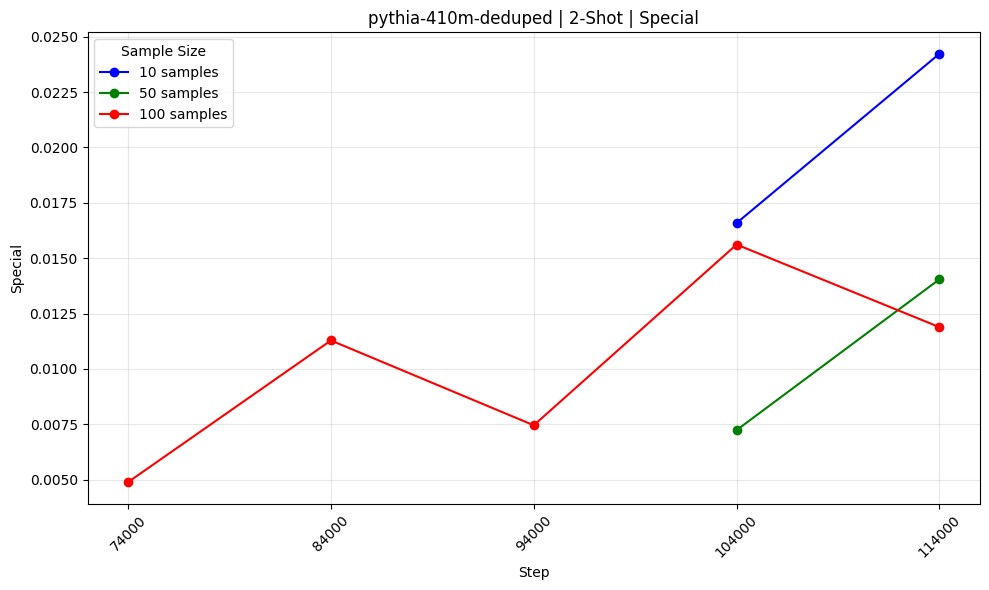

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


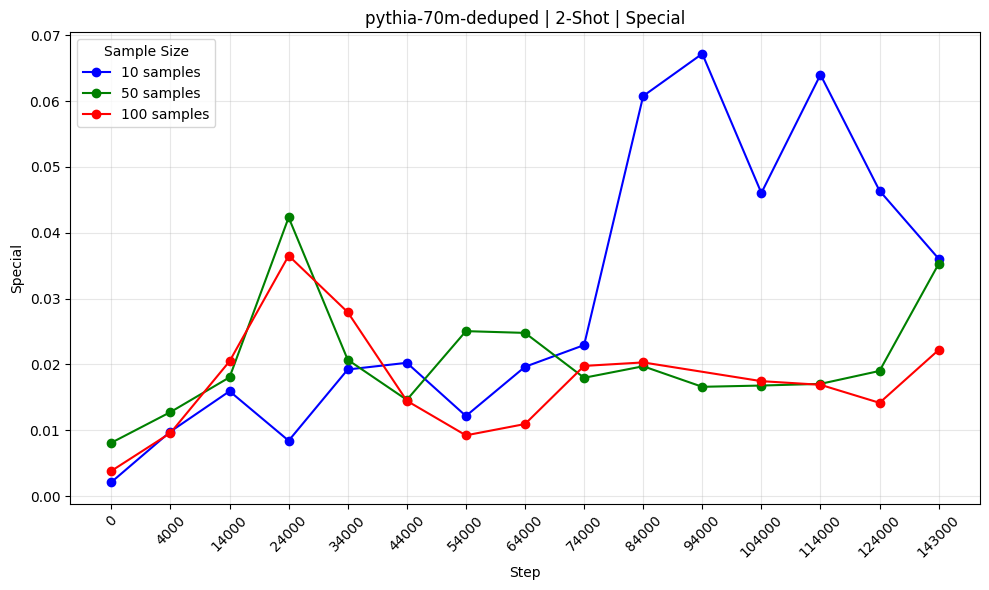

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


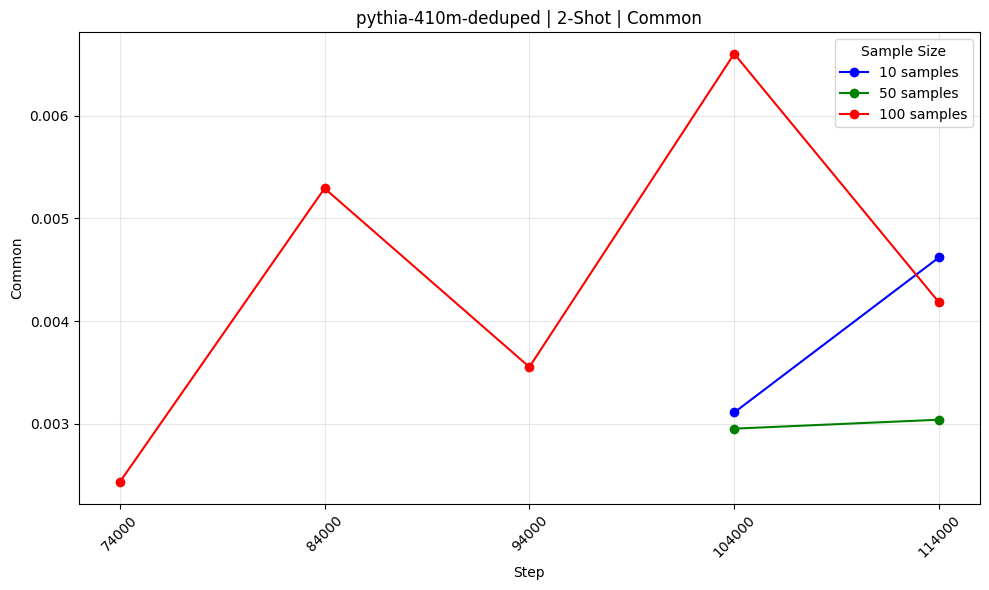

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


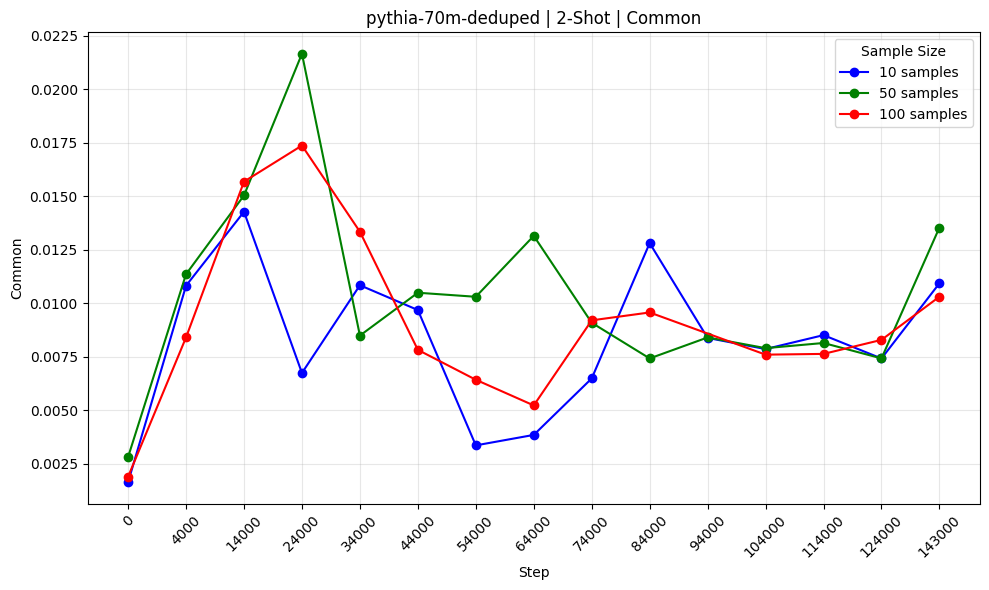

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [7]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/classify'
out_dir= ROOT_dir/'fig/geometry/reflection'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "reflection_stat.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

示例文件树结构：/Users/curiostudio/Desktop/llm_final/classify_updated
└── EleutherAI
    ├── pythia-410m-deduped
    │   └── prob
    │       ├── 0
    │       │   └── 500
    │       │       └── 100
    │       │           └── 2
    │       │               └── individual
    │       │                   ├── classification_baseline.json
    │       │                   └── separation_analysis_baseline.json
    │       ├── 104000
    │       │   └── 500
    │       │       ├── 10
    │       │       │   ├── 2
    │       │       │   │   └── individual
    │       │       │   │       ├── classification_baseline.json
    │       │       │   │       ├── classification.json
    │       │       │   │       ├── separation_analysis_baseline.json
    │       │       │   │       └── separation_analysis.json
    │       │       │   └── 3
    │       │       │       └── individual
    │       │       │           ├── classification.json
    │       │       │           └── separation_analysis.json
    │       │       ├── 100

！！！注意：这部分代码是专门处理htsr数据的（见for f in root.rglob('htsr/**/prob/*.json'):—），所以如果是混合上面部分的geometry，也可以直接把母文件路径给它自动跳过不相关数据

In [1]:
##classify-htsr

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# —— 原有映射，保持不变 —— 
SETTING_MAP = {"group_best":"gbest","group_target_size":"gtsize","individual":"indiv"}
MODEL_MAP   = {"pythia-70m-deduped":"70m","pythia-410m-deduped":"410m"}

NEURONS    = [10,50,100]           # 对应文件 500_10.json, 500_50.json, 500_100.json
COLORS     = ['blue','green','red']
CASE_LIST  = ["boost","suppress","random_1"]
CASE_STYLE = {
    "boost":    {"marker":"o","linestyle":"-"},
    "suppress": {"marker":"s","linestyle":"--"},
    "random_1": {"marker":"^","linestyle":":"},
}

# —— 我们的新指标配置 —— 
STAT_CONFIGS = [
    {"name":"ESD Spike Separation","section":"esd_shape","subsection":None,
     "key":"spike_separation","yrange":None},
    {"name":"PL Alpha Hill (↓ heavier tail)","section":"shape_metrics","subsection":None,
     "key":"pl_alpha_hill","yrange":None},
    {"name":"Phase Structured Indicator","section":"phase_transition","subsection":None,
     "key":"phase_metric","yrange":(-2.1,0.5)},
    {"name":"Bulk–Spike Interaction Strength","section":"bulk_spike_interaction","subsection":None,
     "key":"interaction_strength","yrange":None},
]

CMP_CONFIGS = [
    {"name":"Alpha Hill: Boost vs Common","key":"alpha_hill_boost_vs_common"},
    {"name":"Alpha Hill: Suppress vs Common","key":"alpha_hill_suppress_vs_common"},
    {"name":"Alpha Hill: Suppress vs Boost","key":"alpha_hill_suppress_vs_boost"},
    {"name":"Stable Rank: Boost vs Common","key":"stable_rank_boost_vs_common"},
    {"name":"Stable Rank: Suppress vs Common","key":"stable_rank_suppress_vs_common"},
    {"name":"Stable Rank: Suppress vs Boost","key":"stable_rank_suppress_vs_boost"},
    {"name":"Entropy: Boost vs Common","key":"entropy_boost_vs_common"},
    {"name":"Entropy: Suppress vs Common","key":"entropy_suppress_vs_common"},
    {"name":"Entropy: Suppress vs Boost","key":"entropy_suppress_vs_boost"},
]

def slugify(text):
    return re.sub(r'\W+','_', text).strip('_').lower()

def load_all_json(root_dir):
    root = Path(root_dir)
    recs = []
    for f in root.rglob('htsr/**/prob/*.json'):
        parts = list(f.relative_to(root).parts)
        # 去掉末尾的 'prob' 与文件名
        dir_parts = parts[:-2]
        recs.append({
            'dir_parts': dir_parts,
            'filename': f.name,
            'data': json.loads(f.read_text(encoding='utf-8'))
        })
    return recs

def plot_combined(root_dir, out_dir):
    recs = load_all_json(root_dir)

    # 按所在文件夹分组
    groups = {}
    for r in recs:
        key = tuple(r['dir_parts'])
        groups.setdefault(key, []).append(r)

    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    ncols = 2
    nrows = (len(STAT_CONFIGS)+1)//2

    for dir_parts, files in groups.items():
        # 生成图标题
        title_parts = [SETTING_MAP.get(p, MODEL_MAP.get(p, p)) for p in dir_parts]
        suptitle = " | ".join(title_parts)

        # 收集不同 size（10/50/100）对应的数据
        data_dict = {}
        for r in files:
            m = re.match(r'500_(\d+)\.json', r['filename'])
            if m:
                size = int(m.group(1))
                data_dict[size] = r['data']
        if not data_dict:
            continue

        # —— 第一张：四个指标折线图 —— 
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(ncols*6, nrows*4),
                                 squeeze=False)
        axes = axes.flatten()

        for ax, stat in zip(axes, STAT_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                # x 轴：样本 ID，为了可视化我们用排序后的整数 ID
                steps = sorted(int(k) for k in data.keys())
                x = steps

                for case in CASE_LIST:
                    y = []
                    for s in steps:
                        entry = data[str(s)].get(case, {})
                        # 对 phase 字段单独处理
                        if stat["key"] == "phase":
                            phase = entry.get("phase_transition",{}).get("phase")
                            v = 1.0 if phase == "structured" else 0.0
                        else:
                            v = entry.get(stat["section"],{}).get(stat["key"])
                        y.append(np.nan if v is None else v)

                    if all(np.isnan(y)):
                        continue

                    style = CASE_STYLE[case]
                    ax.plot(x, y,
                            color=COLORS[i],
                            marker=style["marker"],
                            linestyle=style["linestyle"],
                            label=f"{case} {nn}")
                    any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel(stat["name"])
            
            if stat["yrange"]:
                ax.set_ylim(*stat["yrange"])
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples / Case", fontsize='small')

        fig.suptitle(suptitle, fontsize=14)
        fig.tight_layout(rect=[0,0,1,0.95])
        fname1 = out / f"{slugify(suptitle)}_metrics.png"
        fig.savefig(fname1, dpi=200)
        plt.close(fig)
        print(f"Saved {fname1}")

        # —— 第二张：三项跨组比较 —— 
        fig2, axes2 = plt.subplots(1, len(CMP_CONFIGS),
                                   figsize=(len(CMP_CONFIGS)*5, 4),
                                   squeeze=False)
        axes2 = axes2.flatten()

        for ax, cmp_stat in zip(axes2, CMP_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                steps = sorted(int(k) for k in data.keys())
                x = steps
                y = []
                for s in steps:
                    comp = data[str(s)].get("comparisons", {})
                    # 根据 key 前缀选择所属子模块
                    if cmp_stat["key"].startswith("alpha_hill"):
                        v = comp.get("shape_metrics",{}).get(cmp_stat["key"])
                    elif cmp_stat["key"].startswith("spike"):
                        v = comp.get("esd_shape",{}).get(cmp_stat["key"])
                    else:
                        v = comp.get("bulk_spike_interaction",{}).get(cmp_stat["key"])
                    y.append(np.nan if v is None else v)

                if all(np.isnan(y)):
                    continue

                # 直接重用 CASE_STYLE 里的 marker/linestyle，也可以定义新的 CMP_STYLE
                style = CASE_STYLE.get(cmp_stat["key"].split("_")[0], {"marker":"o","linestyle":"-"})
                ax.plot(x, y,
                        color=COLORS[i],
                        marker=style["marker"],
                        linestyle=style["linestyle"],
                        label=str(nn))
                any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(cmp_stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Δ Value")
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples", fontsize='small')

        fig2.suptitle(suptitle + " — Comparisons", fontsize=14)
        fig2.tight_layout(rect=[0,0,1,0.93])
        fname2 = out / f"{slugify(suptitle)}_comparisons.png"
        fig2.savefig(fname2, dpi=200)
        plt.close(fig2)
        print(f"Saved {fname2}")

# —— 示例调用 —— 
if __name__ == '__main__':
    plot_combined(
        root_dir='/Users/jliu/workspace/RAG/results/geometry',
        out_dir='/Users/jliu/workspace/RAG/fig/geometry/htsr'
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_comparisons.png


In [4]:
import typing as t
from pathlib import Path
import re
import json
import numpy as np
import matplotlib.pyplot as plt

# First, update the STAT_CONFIGS to include explicit y-axis ranges for all metrics
STAT_CONFIGS = [
    {"name":"ESD Spike Separation", "section":"esd_shape", "subsection":None,
     "key":"spike_separation", "yrange":(0, 5)},  # Added fixed range
    {"name":"PL Alpha Hill (↓ heavier tail)", "section":"shape_metrics", "subsection":None,
     "key":"pl_alpha_hill", "yrange":(0, 20)},  # Added fixed range
    {"name":"Phase Structured Indicator", "section":"phase_transition", "subsection":None,
     "key":"phase_metric", "yrange":(-2.1, 0.5)},  # Already had range
    {"name":"Bulk–Spike Interaction Strength", "section":"bulk_spike_interaction", "subsection":None,
     "key":"interaction_strength", "yrange":(0, 1.5)},  # Added fixed range
]

# Also add y-axis ranges for comparison plots
CMP_CONFIGS = [
    {"name":"Alpha Hill: Boost vs Common", "key":"alpha_hill_boost_vs_common", "yrange":(0, 20)},
    {"name":"Alpha Hill: Suppress vs Common", "key":"alpha_hill_suppress_vs_common", "yrange":(0, 20)},
    {"name":"Alpha Hill: Suppress vs Boost", "key":"alpha_hill_suppress_vs_boost", "yrange":(0, 20)},
    {"name":"Stable Rank: Boost vs Common", "key":"stable_rank_boost_vs_common", "yrange":(-50, 50)},
    {"name":"Stable Rank: Suppress vs Common", "key":"stable_rank_suppress_vs_common", "yrange":(-50, 50)},
    {"name":"Stable Rank: Suppress vs Boost", "key":"stable_rank_suppress_vs_boost", "yrange":(-50, 50)},
    {"name":"Entropy: Boost vs Common", "key":"entropy_boost_vs_common", "yrange":(-0.5, 0.5)},
    {"name":"Entropy: Suppress vs Common", "key":"entropy_suppress_vs_common", "yrange":(-0.5, 0.5)},
    {"name":"Entropy: Suppress vs Boost", "key":"entropy_suppress_vs_boost", "yrange":(-0.5, 0.5)},
]

def plot_combined(root_dir: str, out_dir: str) -> None:
    """
    Plot combined metrics and comparisons with fixed y-axis ranges.
    
    Args:
        root_dir: Root directory containing the data files
        out_dir: Output directory for saving plots
    """
    recs = load_all_json(root_dir)

    # Group by directory
    groups: dict[tuple[str, ...], list[dict]] = {}
    for r in recs:
        key = tuple(r['dir_parts'])
        groups.setdefault(key, []).append(r)

    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)
    ncols = 2
    nrows = (len(STAT_CONFIGS) + 1) // 2

    for dir_parts, files in groups.items():
        # Generate title
        title_parts = [SETTING_MAP.get(p, MODEL_MAP.get(p, p)) for p in dir_parts]
        suptitle = " | ".join(title_parts)

        # Collect data for different sizes (10/50/100)
        data_dict: dict[int, dict] = {}
        for r in files:
            m = re.match(r'500_(\d+)\.json', r['filename'])
            if m:
                size = int(m.group(1))
                data_dict[size] = r['data']
        if not data_dict:
            continue

        # First figure: four metrics line plots
        fig, axes = plt.subplots(nrows, ncols,
                                figsize=(ncols*6, nrows*4),
                                squeeze=False)
        axes = axes.flatten()

        for ax, stat in zip(axes, STAT_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                # x-axis: sample ID
                steps = sorted(int(k) for k in data.keys())
                x = steps

                for case in CASE_LIST:
                    y = []
                    for s in steps:
                        entry = data[str(s)].get(case, {})
                        # Special handling for phase field
                        if stat["key"] == "phase":
                            phase = entry.get("phase_transition", {}).get("phase")
                            v = 1.0 if phase == "structured" else 0.0
                        else:
                            section_data = entry.get(stat["section"], {})
                            v = section_data.get(stat["key"]) if section_data else None
                        y.append(np.nan if v is None else v)

                    if all(np.isnan(y)):
                        continue

                    style = CASE_STYLE[case]
                    ax.plot(x, y,
                           color=COLORS[i],
                           marker=style["marker"],
                           linestyle=style["linestyle"],
                           label=f"{case} {nn}")
                    any_curve = True

            if not any_curve:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', alpha=0.3)

            ax.set_title(stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel(stat["name"])
            
            # Always set y-axis range if provided
            if stat["yrange"] is not None:
                ax.set_ylim(*stat["yrange"])
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples / Case", fontsize='small')

        fig.suptitle(suptitle, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fname1 = out / f"{slugify(suptitle)}_metrics.png"
        fig.savefig(fname1, dpi=200)
        plt.close(fig)
        print(f"Saved {fname1}")

        # Second figure: comparisons
        fig2, axes2 = plt.subplots(1, len(CMP_CONFIGS),
                                 figsize=(len(CMP_CONFIGS)*5, 4),
                                 squeeze=False)
        axes2 = axes2.flatten()

        for ax, cmp_stat in zip(axes2, CMP_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                steps = sorted(int(k) for k in data.keys())
                x = steps
                y = []
                for s in steps:
                    comp = data[str(s)].get("comparisons", {})
                    # Choose appropriate submodule based on key prefix
                    if cmp_stat["key"].startswith("alpha_hill"):
                        v = comp.get("shape_metrics", {}).get(cmp_stat["key"])
                    elif cmp_stat["key"].startswith("spike"):
                        v = comp.get("esd_shape", {}).get(cmp_stat["key"])
                    else:
                        v = comp.get("bulk_spike_interaction", {}).get(cmp_stat["key"])
                    y.append(np.nan if v is None else v)

                if all(np.isnan(y)):
                    continue

                style = CASE_STYLE.get(cmp_stat["key"].split("_")[0], {"marker":"o", "linestyle":"-"})
                ax.plot(x, y,
                       color=COLORS[i],
                       marker=style["marker"],
                       linestyle=style["linestyle"],
                       label=str(nn))
                any_curve = True

            if not any_curve:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', alpha=0.3)

            ax.set_title(cmp_stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Δ Value")
            
            # Apply fixed y-axis range if provided
            if "yrange" in cmp_stat and cmp_stat["yrange"] is not None:
                ax.set_ylim(*cmp_stat["yrange"])
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples", fontsize='small')

        fig2.suptitle(suptitle + " — Comparisons", fontsize=14)
        fig2.tight_layout(rect=[0, 0, 1, 0.93])
        fname2 = out / f"{slugify(suptitle)}_comparisons.png"
        fig2.savefig(fname2, dpi=200)
        plt.close(fig2)
        print(f"Saved {fname2}")



# —— 示例调用 —— 
if __name__ == '__main__':
    plot_combined(
        root_dir='/Users/jliu/workspace/RAG/results/geometry',
        out_dir='/Users/jliu/workspace/RAG/fig/geometry/htsr'
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_comparisons.png


示例文件夹树结构：/Users/curiostudio/Desktop/llm_final/classify_updated
└── EleutherAI
    ├── pythia-410m-deduped
    │   └── prob
    │       ├── 0
    │       │   └── 500
    │       │       └── 100
    │       │           └── 2
    │       │               └── individual
    │       │                   ├── classification_baseline.json
    │       │                   └── separation_analysis_baseline.json
    │       ├── 104000
    │       │   └── 500
    │       │       ├── 10
    │       │       │   ├── 2
    │       │       │   │   └── individual
    │       │       │   │       ├── classification_baseline.json
    │       │       │   │       ├── classification.json
    │       │       │   │       ├── separation_analysis_baseline.json
    │       │       │   │       └── separation_analysis.json
    │       │       │   └── 3
    │       │       │       └── individual
    │       │       │           ├── classification.json
    │       │       │           └── separation_analysis.json
    
!!!注意：以下版本是处理带_baseline版本的新数据，如果命名更改的话注意是否带_baseline

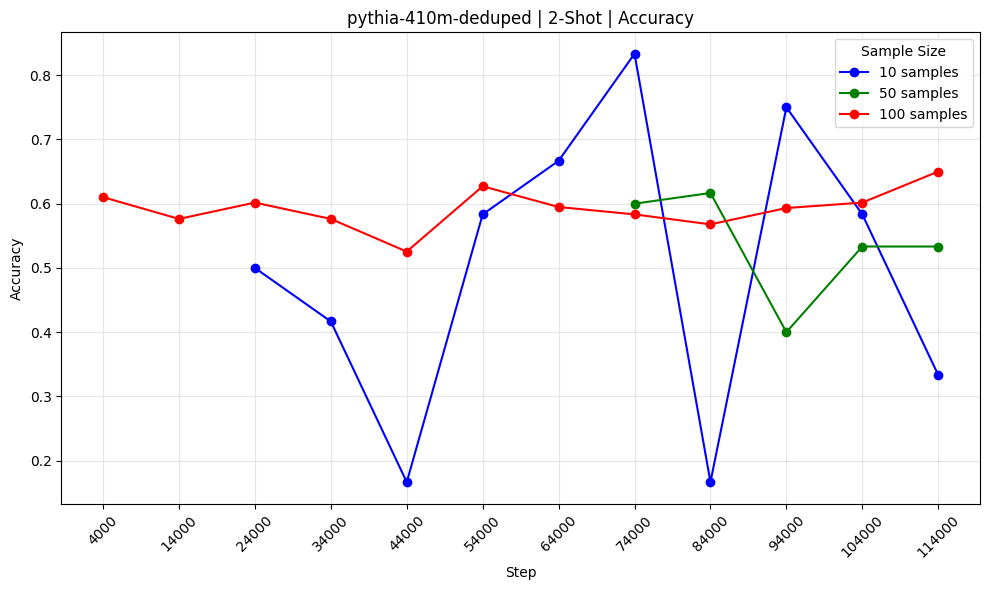

Saved plot to plots_classify_updated0509/pythia_410m_deduped_shot2_accuracy.png


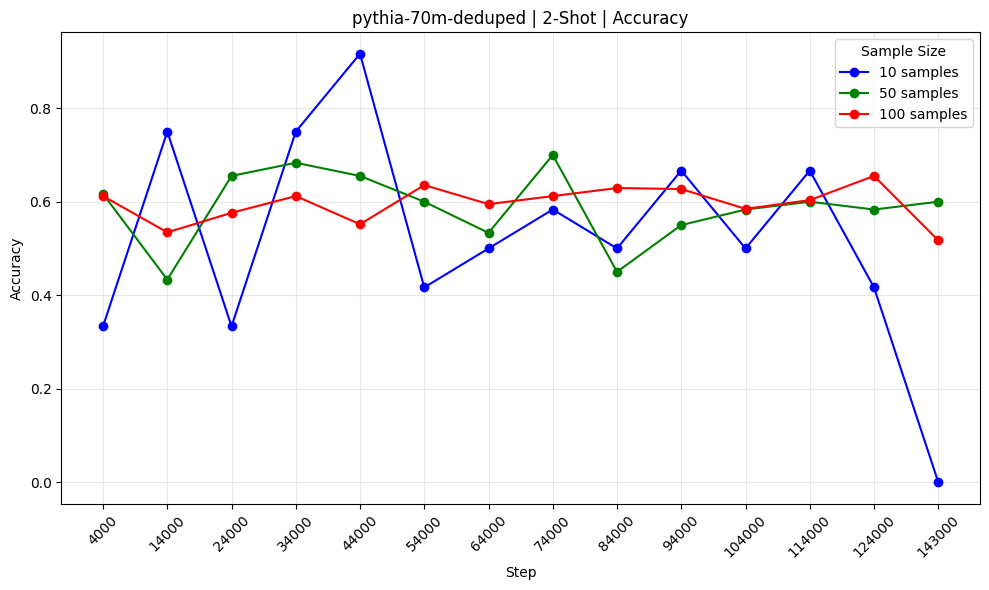

Saved plot to plots_classify_updated0509/pythia_70m_deduped_shot2_accuracy.png


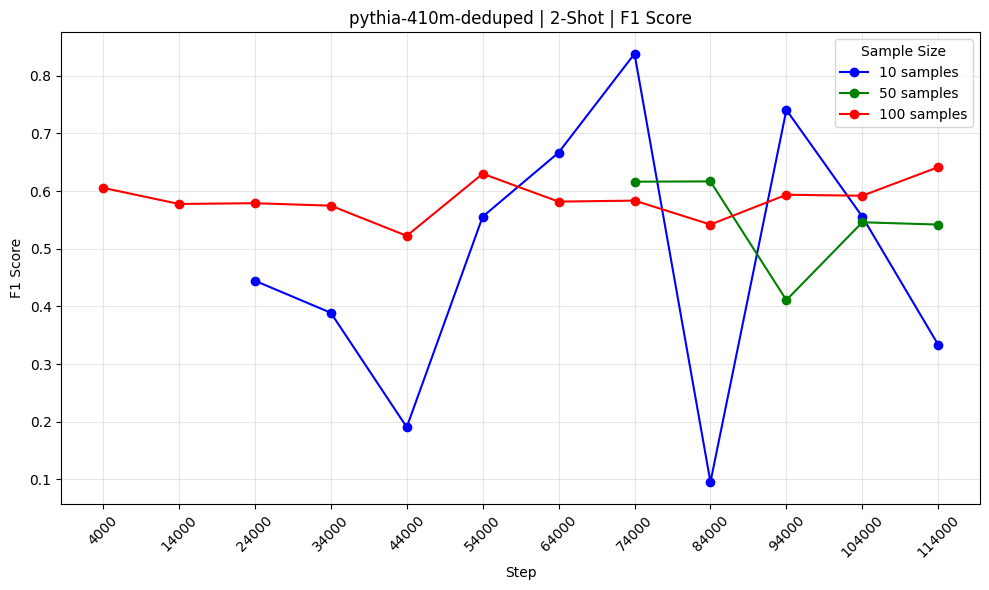

Saved plot to plots_classify_updated0509/pythia_410m_deduped_shot2_f1_score.png


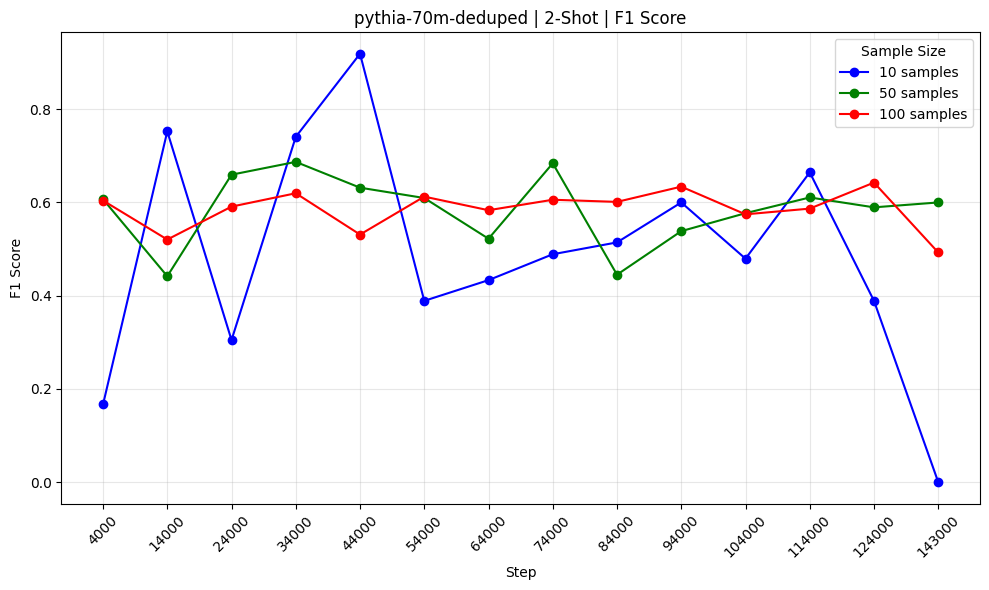

Saved plot to plots_classify_updated0509/pythia_70m_deduped_shot2_f1_score.png


In [5]:
# Separation Analysis Notebook

## Cell 1: Imports and Settings

import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# ========== User-Configurable Settings ==========
# Root of your 'classify' folder\
ROOT_DIR = Path('/Users/curiostudio/Desktop/llm_final/classify_updated')\
# Choose shot: 2 or 3\
SHOT_CHOICE = 2\
# Sample sizes to keep\
SAMPLE_SIZES = [10, 50, 100, 'unified']\
# Output directory for plots\
OUT_DIR = Path('plots_classify_updated0509')\
# Optional: whether to display plots inline\
SHOW_PLOTS = True\
# ===============================================


## Cell 2: Data Collection (Only Individual Config)

def slugify(text: str) -> str:
    """Convert arbitrary text into a filesystem-safe slug."""
    return re.sub(r'[^A-Za-z0-9]+', '_', text).strip('_').lower()


def collect_separation_data(
    root_dir: Path,
    shot: int,
    sample_sizes=tuple(SAMPLE_SIZES)
) -> pd.DataFrame:
    """
    Traverse all separation_analysis.json under ROOT_DIR,
    but only load those under 'individual' directories,
    extract average_performance accuracy & f1_score for the given shot and sample_sizes.
    Returns a DataFrame with columns: ['model', 'step', 'sample_size', 'accuracy', 'f1_score']
    """
    records = []
    for json_path in root_dir.rglob('separation_analysis_baseline.json'):
        # Expected structure:
        # EleutherAI/<model>/prob/<step>/500/<sample_size>/<shot>/individual/separation_analysis.json
        parts = json_path.relative_to(root_dir).parts
        if len(parts) < 9 or parts[0] != 'EleutherAI' or parts[2] != 'prob':
            continue
        # Only include 'individual' config, skip group_best, group_target_size, unified, etc.
        if parts[7] != 'individual':
            continue

        model = parts[1]
        try:
            step = int(parts[3])
            sample_size = int(parts[5])
            sh = int(parts[6])
        except ValueError:
            # Skip non-numeric directories
            continue

        # Filter by shot and sample size
        if sh != shot or sample_size not in sample_sizes:
            continue
        # Skip non-positive step to avoid log(0)
        if step <= 0:
            continue

        # Load JSON and extract
        data = json.loads(json_path.read_text(encoding='utf-8'))
        avg = data['key_metrics']['average_performance']
        records.append({
            'model': model,
            'step': step,
            'sample_size': sample_size,
            'accuracy': avg.get('accuracy'),
            'f1_score': avg.get('f1_score'),
        })

    df = pd.DataFrame.from_records(records)
    if df.empty:
        raise RuntimeError(f"No data found for {shot}-shot with sizes {sample_sizes} at {root_dir}")
    # Sort by model and step
    return df.sort_values(['model','step'])

## Cell 3: Plotting with Categorical X-Axis

def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")

## Cell 4: Execute Collection & Plotting

# 1. Collect the filtered data
df_all = collect_separation_data(ROOT_DIR, SHOT_CHOICE)

# 2. Plot both metrics
for metric in ['accuracy', 'f1_score']:
    plot_metrics_by_model(df_all, metric, SHOT_CHOICE, OUT_DIR, show=SHOW_PLOTS)



# Reflection analyses


In [ ]:
def get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)->list:
    """Iterate file names."""
    filepath_lst = []
    file_info = []
    for model_name in model_name_lst:
        for step in step_lst:
            for sample_size in sample_size_lst:
                for class_num in class_num_lst:
                    for group_type in group_type_lst: 
                        filepath_lst.append(DATA_DIR / model_name / "prob" / str(step) / "500" / str(sample_size) / str(class_num) / group_type / filename)
                        file_info.append([model_name,step,sample_size])
    return filepath_lst, file_info


def load_data(filepath, file_info):
    """Extract stat form json file."""
    try:
        data = json.loads(filepath.read_text(encoding='utf-8'))
        records = []
        records.append({
            'model': file_info[0],
            'step': file_info[1],
            'sample_size': file_info[2],
            'special': data["1"].get('delta_loss_diff'),
            'common': data["-1"].get('delta_loss_diff'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(filepath)
        return None
    

# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")



def run_pipeline(DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename):
    """Run the plotting pipeline."""
    # load all file pathss
    filepath_lst, file_info_lst = get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)
    # load all files
    df = pd.DataFrame()
    for file_idx, filepath in enumerate(filepath_lst):
        df_row = load_data(filepath, file_info_lst[file_idx])
        df = pd.concat([df,df_row])

    # plot out the results
    for metric in metric_lst:
        plot_metrics_by_model(
            df,
            metric=metric,
            shot = 2,
            out_dir= out_dir,
            show = True
        )




/Users/jliu/workspace/RAG/results/classify/pythia-70m-deduped/prob/94000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual

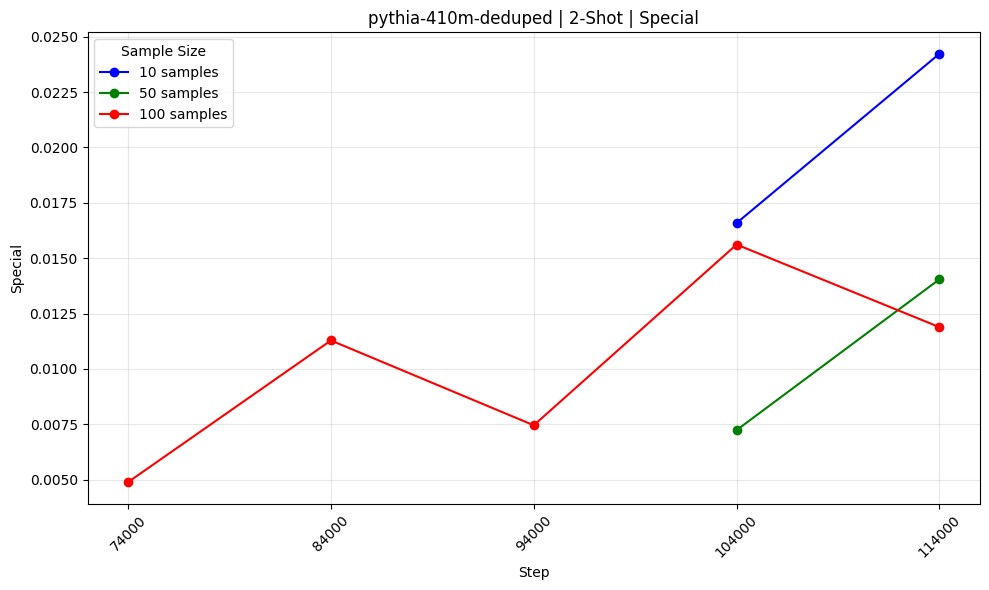

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


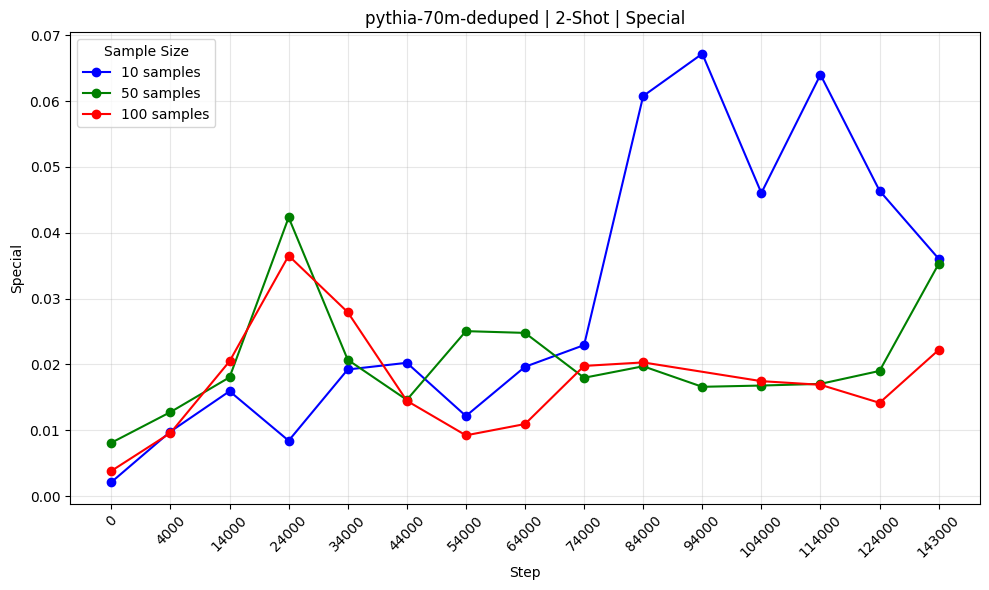

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


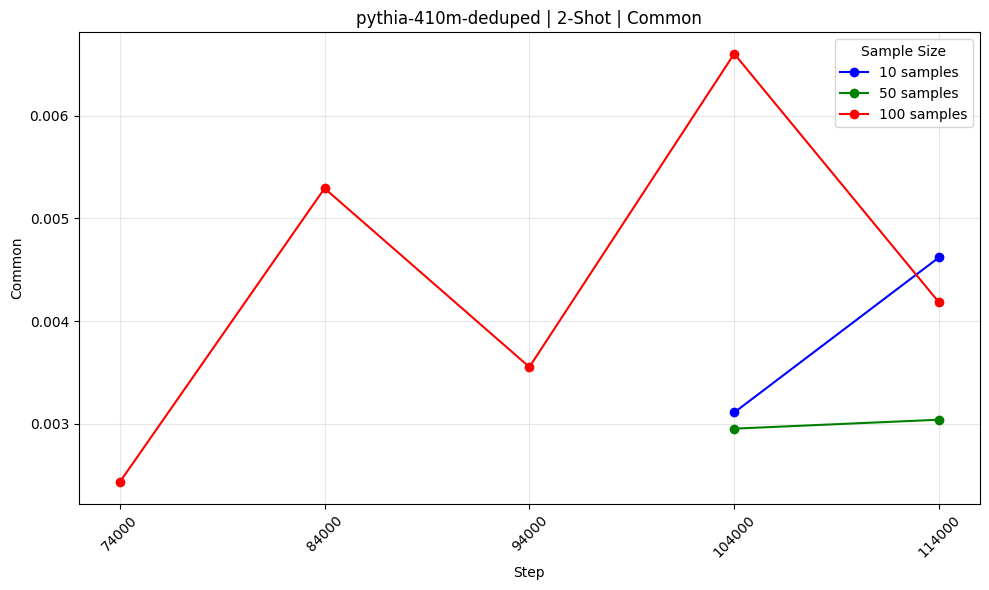

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


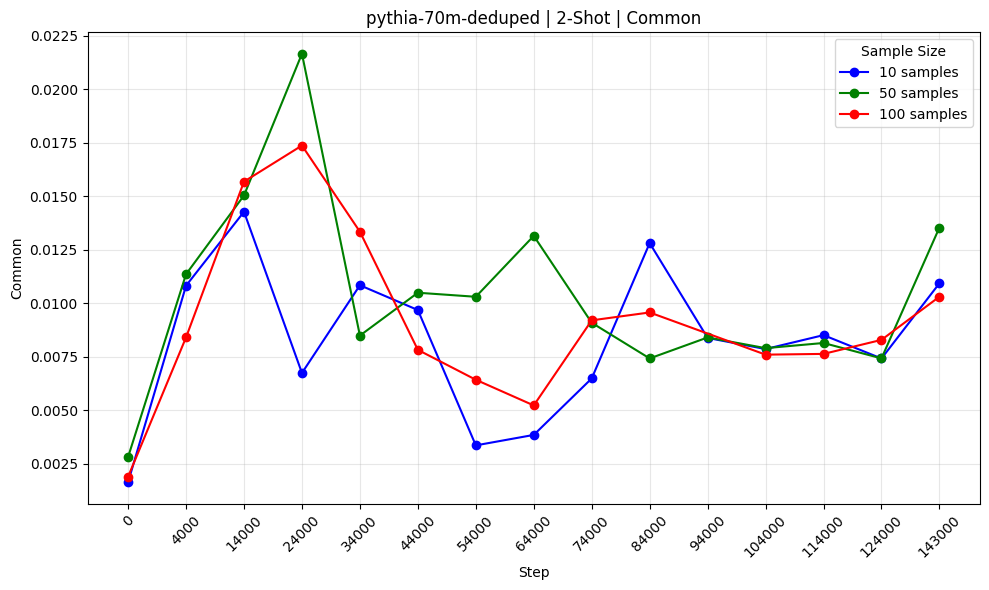

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [49]:
# loop over differento conditions
DATA_DIR = Path('/Users/jliu/workspace/RAG/results/classify')
out_dir= Path('/Users/jliu/workspace/RAG/fig/geometry/reflection')
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "reflection_stat.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

## our assumption: 
special: reduced delta loss after reflection 
-> negative for the comparison


common: increased delta loss 
-> positive for the comparison 